In [164]:
import io
import math
import warnings
from typing import Optional, Tuple

import torch
from torch import Tensor
from torchaudio._internal import module_utils as _mod_utils
import torchaudio
import IPython.display as ipd
from typing import Callable, Optional


In [11]:
def _get_complex_dtype(real_dtype: torch.dtype):
    if real_dtype == torch.double:
        return torch.cdouble
    if real_dtype == torch.float:
        return torch.cfloat
    if real_dtype == torch.half:
        return torch.complex32
    raise ValueError(f'Unexpected dtype {real_dtype}')

In [39]:
def get_complex_spectrogram(waveform, n_fft = 2048, win_len = 2048, hop_len = 512, power=None):
    spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_len,
    hop_length=hop_len,
    center=True,
    pad_mode="reflect",
    power=power,
    return_complex=0,
    )
    return spectrogram(waveform)

def get_spectrogram(waveform, n_fft = 2048, win_len = 2048, hop_len = 512, power=2):
    spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_len,
    hop_length=hop_len,
    center=True,
    pad_mode="reflect",
    power=power,
    )
    return spectrogram(waveform)

In [106]:
waveform, sr = torchaudio.load('/data2/personal/jaejun/inpainting/results/210725/3/validation_30/0_gt.wav')
spec_mag = get_spectrogram(waveform)
complex_spec = get_complex_spectrogram(waveform)
torch_gflim = torchaudio.transforms.GriffinLim(n_fft=2048, n_iter=60, win_length=2048, hop_length=512)
ipd.Audio(waveform, rate=sr)

In [107]:
complex_spec_comp = torch.view_as_complex(complex_spec)
mag = torch.abs(complex_spec_comp)
phase = torch.angle(complex_spec_comp)

In [108]:
real = torch.cos(phase)*mag
imaginary = torch.sin(phase)*mag
cat = torch.cat([real.unsqueeze(-1), imaginary.unsqueeze(-1)], -1)
print(real.shape, imaginary.shape)
recon_waveform1 = torch.istft(cat, 2048, 512, 2048)
ipd.Audio(recon_waveform1, rate=sr)

torch.Size([1, 1025, 431]) torch.Size([1, 1025, 431])


In [114]:
mask = torch.zeros([1, 1025, 431])
mask[...,100:200] = 1

In [123]:
specgram = spec_mag
power = 2

shape = specgram.size()
specgram = specgram.reshape([-1] + list(shape[-2:]))

specgram = specgram.pow(1 / power)

In [127]:
specgram.shape, spec_mag.shape

(torch.Size([1, 1025, 431]), torch.Size([1, 1025, 431]))

In [258]:
def custom_griffinlim(specgram, input_angle, mask, window, n_fft, hop_length, win_length, power, n_iter,
                      momentum, length: Optional, angle_init='rand'):
    assert momentum < 1, 'momentum={} > 1 can be unstable'.format(momentum)
    assert momentum >= 0, 'momentum={} < 0'.format(momentum)

    # pack batch
    shape = specgram.size()
    specgram = specgram.reshape([-1] + list(shape[-2:]))
    specgram = specgram.pow(1 / power)
    
    if input_angle != None and mask != None:
        _input_angle = input_angle
        _mask = mask
        
    # initialize the phase
    if angle_init == 'rand':
        angles = torch.rand(
            specgram.size(),
            dtype=_get_complex_dtype(specgram.dtype), device=specgram.device)
    elif angle_init == 'one':
        angles = torch.full(
            specgram.size(), 1,
            dtype=_get_complex_dtype(specgram.dtype), device=specgram.device)
    elif angle_init == 'zero':
        angles = torch.full(
            specgram.size(), 0,
            dtype=_get_complex_dtype(specgram.dtype), device=specgram.device)


    # And initialize the previous iterate to 0
    tprev = torch.tensor(0., dtype=specgram.dtype, device=specgram.device)
    for _ in range(n_iter):
        angles = _input_angle*(1-_mask) + angles * _mask
        # Invert with our current estimate of the phases
        inverse = torch.istft(specgram * angles,
                              n_fft=n_fft,
                              hop_length=hop_length,
                              win_length=win_length,
                              window=window,
                              length=length)

        # Rebuild the spectrogram
        rebuilt = torch.stft(
            input=inverse,
            n_fft=n_fft,
            hop_length=hop_length,
            win_length=win_length,
            window=window,
            center=True,
            pad_mode='reflect',
            normalized=False,
            onesided=True,
            return_complex=True,
        )

        # Update our phase estimates
        angles = rebuilt
        if momentum:
            angles = angles - tprev.mul_(momentum / (1 + momentum))
        angles = angles.div(angles.abs().add(1e-16))

        # Store the previous iterate
        tprev = rebuilt

    # Return the final phase estimates
    waveform = torch.istft(specgram * angles,
                           n_fft=n_fft,
                           hop_length=hop_length,
                           win_length=win_length,
                           window=window,
                           length=length
                          )

    # unpack batch
    waveform = waveform.reshape(shape[:-2] + waveform.shape[-1:])

    return waveform


In [259]:
class Custom_GriffinLim(torch.nn.Module):
    r"""Compute waveform from a linear scale magnitude spectrogram using the Griffin-Lim transformation.

    Implementation ported from
    :footcite:`brian_mcfee-proc-scipy-2015`, :footcite:`6701851` and :footcite:`1172092`.

    Args:
        n_fft (int, optional): Size of FFT, creates ``n_fft // 2 + 1`` bins. (Default: ``400``)
        n_iter (int, optional): Number of iteration for phase recovery process. (Default: ``32``)
        win_length (int or None, optional): Window size. (Default: ``n_fft``)
        hop_length (int or None, optional): Length of hop between STFT windows. (Default: ``win_length // 2``)
        window_fn (Callable[..., Tensor], optional): A function to create a window tensor
            that is applied/multiplied to each frame/window. (Default: ``torch.hann_window``)
        power (float, optional): Exponent for the magnitude spectrogram,
            (must be > 0) e.g., 1 for energy, 2 for power, etc. (Default: ``2``)
        wkwargs (dict or None, optional): Arguments for window function. (Default: ``None``)
        momentum (float, optional): The momentum parameter for fast Griffin-Lim.
            Setting this to 0 recovers the original Griffin-Lim method.
            Values near 1 can lead to faster convergence, but above 1 may not converge. (Default: ``0.99``)
        length (int, optional): Array length of the expected output. (Default: ``None``)
        rand_init (bool, optional): Initializes phase randomly if True and to zero otherwise. (Default: ``True``)
    """
    __constants__ = ['n_fft', 'n_iter', 'win_length', 'hop_length', 'power',
                     'length', 'momentum', 'rand_init']

    def __init__(self,
                 n_fft: int = 400,
                 n_iter: int = 32,
                 win_length: Optional[int] = None,
                 hop_length: Optional[int] = None,
                 window_fn: Callable[..., Tensor] = torch.hann_window,
                 power: float = 2.,
                 wkwargs: Optional[dict] = None,
                 momentum: float = 0.99,
                 length: Optional[int] = None,
                 rand_init: str = 'one') -> None:
        super(Custom_GriffinLim, self).__init__()

        assert momentum < 1, 'momentum={} > 1 can be unstable'.format(momentum)
        assert momentum >= 0, 'momentum={} < 0'.format(momentum)

        self.n_fft = n_fft
        self.n_iter = n_iter
        self.win_length = win_length if win_length is not None else n_fft
        self.hop_length = hop_length if hop_length is not None else self.win_length // 2
        window = window_fn(self.win_length) if wkwargs is None else window_fn(self.win_length, **wkwargs)
        self.register_buffer('window', window)
        self.length = length
        self.power = power
        self.momentum = momentum / (1 + momentum)
        self.rand_init = rand_init

    def forward(self, specgram: Tensor, input_angle: Tensor, mask: Tensor) -> Tensor:
        r"""
        Args:
            specgram (Tensor):
                A magnitude-only STFT spectrogram of dimension (..., freq, frames)
                where freq is ``n_fft // 2 + 1``.

        Returns:
            Tensor: waveform of (..., time), where time equals the ``length`` parameter if given.
        """
        return custom_griffinlim(specgram, input_angle, mask, self.window, self.n_fft, self.hop_length, self.win_length, self.power,
                            self.n_iter, self.momentum, self.length, self.rand_init)

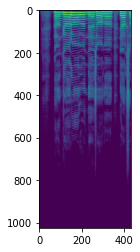

In [264]:
# 기본 torch griffinlim : 전체 griffin lim
recon1 = torch_gflim(spec_mag)
plt.imshow(torch.tensor(librosa.power_to_db(get_spectrogram(recon1)))[0])
plt.show()
ipd.Audio(recon1, rate=sr)

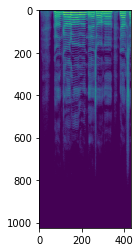

In [272]:
# custom griffinlim : 전체 griffin lim (recon1과 동일한지 확인)
mask_whole = torch.ones(spec_mag.shape)
recon2 = custom_griffinlim(spec_mag, complex_spec_comp, mask_whole, window=torch.hann_window(2048), n_fft=2048, hop_length=512,
                          win_length=2048, power=2, n_iter=60, momentum=0.99, length=None, angle_init='rand')
plt.imshow(torch.tensor(librosa.power_to_db(get_spectrogram(recon2)))[0])
plt.show()
ipd.Audio(recon2, rate=sr)

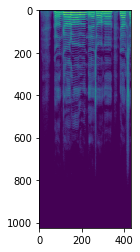

In [273]:
# custom griffinlim : 특정 mask 영역 제외한 phase 를 입력해주기 (complex 형태)
recon3 = custom_griffinlim(spec_mag, complex_spec_comp, mask, window=torch.hann_window(2048), n_fft=2048, hop_length=512,
                          win_length=2048, power=2, n_iter=60, momentum=0.99, length=None, angle_init='one')
plt.imshow(torch.tensor(librosa.power_to_db(get_spectrogram(recon3)))[0])
plt.show()
ipd.Audio(recon3, rate=sr)

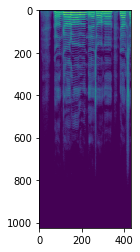

In [274]:
# Class로 만든 custom griffinlim : 특정 mask 영역 제외한 phase 를 입력해주기 (complex 형태)
custom_gflim = Custom_GriffinLim(n_fft=2048, n_iter=60, win_length=2048, hop_length=512)
recon4 = custom_gflim(spec_mag, complex_spec_comp, mask)
plt.imshow(torch.tensor(librosa.power_to_db(get_spectrogram(recon3)))[0])
plt.show()
ipd.Audio(recon4, rate=sr)

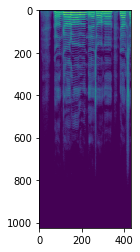

In [276]:
# Class로 만든 custom griffinlim : 특정 mask 영역 제외한 phase 를 입력해주기 (normalized complex 형태)
n_real = real / mag
n_imaginary = imaginary / mag
n_cat = torch.cat([n_real.unsqueeze(-1), n_imaginary.unsqueeze(-1)], -1)
t = torch.view_as_complex(n_cat)
custom_gflim = Custom_GriffinLim(n_fft=2048, n_iter=60, win_length=2048, hop_length=512)
recon5 = custom_gflim(spec_mag, t, mask)
plt.imshow(torch.tensor(librosa.power_to_db(get_spectrogram(recon3)))[0])
plt.show()
ipd.Audio(recon5, rate=sr)

In [277]:
# normalize 해서 넣든 안해서 넣든 큰 차이가 없는 것으로 보인다 (어차피 각도만 뽑는듯)
recon4, recon5

(tensor([[0.0035, 0.0036, 0.0034,  ..., 0.1044, 0.1298, 0.1474]]),
 tensor([[0.0032, 0.0034, 0.0033,  ..., 0.0998, 0.1046, 0.1087]]))